In [ ]:
%%capture
!pip install pytorch-fid

In [ ]:
%%capture
!pip install datasets

In [ ]:
import os
import math
import glob
import torch
import random
import zipfile
import pathlib
import torchvision
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

from os import path
from PIL import Image
from scipy import linalg
from pathlib import Path
from tqdm.auto import tqdm
from tensorflow import keras
from numpy.random import seed
from google.colab import drive
from datasets import load_dataset
from torchvision import transforms
from torchvision.io import read_image
from sklearn.decomposition import PCA
from keras.utils import dataset_utils
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
random_seed = 42

seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

# Caricamento datasets

In [ ]:
%%capture
drive.mount('/content/gdrive', force_remount=True)
with zipfile.ZipFile("/content/gdrive/MyDrive/Datasets/img_align_celeba_for_ncsn.zip","r") as zip_ref:
    zip_ref.extractall()

In [ ]:
base_dir = "/content/img_align_celeba/"
base_dir_32 = "/content/img_align_celeba_center_32/"

if path.exists(base_dir_32) == False:
  os.mkdir(base_dir_32)

for i in tqdm(range(202599)):
  name = "{0:06d}.jpg".format(i+1)

  img_path = base_dir + name
  img = read_image(img_path)
  img = transforms.ToPILImage()(img)

  # center crop
  width, height = img.size  # Get dimensions
  left = (width - 140) / 2
  top = (height - 140) / 2
  right = (width + 140) / 2
  bottom = (height + 140) / 2
  img = img.crop((left, top, right, bottom))

  # resize
  img = transforms.Resize((32, 32))(img)
  output_path = base_dir_32 + name
  img.save(output_path)

  0%|          | 0/202599 [00:00<?, ?it/s]

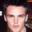

In [ ]:
image.load_img(base_dir_32 + "200000.jpg")

In [ ]:
with zipfile.ZipFile("/content/gdrive/MyDrive/Datasets/ncsn_generated_samples.zip","r") as zip_ref:
    zip_ref.extractall()

samples_dir = "/content/samples/"

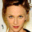

In [ ]:
image.load_img(samples_dir + "image_10.png")

In [ ]:
image_size = (299, 299)

In [ ]:
real_data_32_dir = pathlib.Path(base_dir_32)
seed_ds = 42 
shuffle_value = False
batch_size = 1

real_data_32_ds = tf.keras.preprocessing.image_dataset_from_directory(
    real_data_32_dir,
    labels=None,
    seed=seed_ds,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=shuffle_value)

Found 202599 files belonging to 1 classes.


In [ ]:
ncsn_samples_dir = pathlib.Path(samples_dir)
seed_ds = 42 
shuffle_value = False
batch_size = 1

ncsn_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    ncsn_samples_dir,
    labels=None,
    seed=seed_ds,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=shuffle_value)

Found 106 files belonging to 1 classes.


In [ ]:
def preprocess(images):
  return preprocess_input(images)

real_data_32_ds_preprocessed = real_data_32_ds.map(preprocess)
ncsn_train_ds_preprocessed = ncsn_train_ds.map(preprocess)

# Estrazione features

In [ ]:
model = InceptionV3(weights='imagenet')
model.summary()

96112376/96112376 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
for layer in model.layers:
  layer.trainable = False

feat_extractor_model = Model(inputs=model.input, 
                             outputs=model.get_layer('avg_pool').output)
feat_extractor_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
features_real_data_32 = feat_extractor_model.predict(real_data_32_ds_preprocessed)
print(features_real_data_32.shape)

202599/202599 [==============================] - 3130s 15ms/step


In [ ]:
features_ncsn_train = feat_extractor_model.predict(ncsn_train_ds_preprocessed)
print(features_ncsn_train.shape)

# Calcolo FID

In [ ]:
def compute_fid(features_real, features_generated):
  mu_real = np.mean(features_real, axis=0)
  mu_generated = np.mean(features_generated, axis=0)
  cov_real = np.cov(features_real, rowvar=False)
  cov_generated = np.cov(features_real, rowvar=False)
  diff = np.sum((mu_real - mu_generated)**2.0)
  cov_mean, _ = linalg.sqrtm(cov_real.dot(cov_generated), disp=False)
  if np.iscomplexobj(cov_mean):
    cov_mean = cov_mean.real
  tr_cov_mean = np.trace(cov_mean)
  fid = diff + np.trace(cov_real) + np.trace(cov_generated) - 2 * tr_cov_mean
  return fid

In [ ]:
fid_ncsn_train = compute_fid(features_real_data_32, features_ncsn_train)
print(fid_ncsn_train)